# C - Flux Convolution

## Objective

This notebook builds upon the preceding notebooks, `A-Differential-Neutron-Nucleus-XN.ipynb` and `B-Neutron-Nucleus-Recoil-Distributions.ipynb`. Our goal is to compute a realistic nuclear recoil spectrum — a prediction of how frequently nuclear recoils of various energies will be observed in a detector when neutrons interact with target materials like silicon or germanium.

This spectrum depends on two key factors:

1. Neutron flux spectrum, $\Phi(E_n)$ — the number of neutrons striking the detector per unit energy.
2. Differential recoil cross section, $\frac{d\sigma}{dE_r}(E_n, E_r)$ — the probability that a neutron of energy $E_n$ will produce a recoil of energy $E_r$.

Importantly, the same recoil energy $E_r$ can result from many different neutron energies, depending on the collision geometry. For example, a high-energy neutron glancing off a nucleus at a shallow angle may deposit the same energy as a low-energy neutron hitting head-on.

To account for this, we integrate over all neutron energies that can result in a particular recoil energy:

$$
\frac{dR}{dE_r} = \int_{E_n^{\text{min}}}^{E_n^{\text{max}}} \Phi(E_n) \cdot \frac{d\sigma}{dE_r}(E_n, E_r) \, dE_n
$$

Where:

- $\frac{dR}{dE_r}$ is the recoil rate per unit energy, per unit detector mass, per unit time.
- $\Phi(E_n)$ is the neutron flux at energy $E_n$.
- $\frac{d\sigma}{dE_r}(E_n, E_r)$ is the differential cross section for producing recoil energy $E_r$ from neutron energy $E_n$.

This operation—called flux convolution—combines real-world neutron flux spectra with nuclear physics models to estimate what a detector would actually measure.

We will apply this process to all naturally occurring isotopes of both silicon and germanium, producing flux-convolved recoil spectra for each isotope and for the naturally weighted average of each element.

## Libraries and Style Files

In [1]:
#we may need some code in the ../python directory and/or matplotlib styles

# Add path to local Python modules (../python)
import sys
sys.path.append('../python/')

# Optional: Auto-install missing dependencies (for portability)
import importlib.util
import subprocess

def install_if_missing(pkg_name):
    if importlib.util.find_spec(pkg_name) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])

install_if_missing("periodictable")
install_if_missing("pyteomics")

# Import standard libraries
import numpy as np
import pandas as pd
import scipy.constants as co
from scipy import integrate

# Plotting with a custom style
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

# Import project-specific modules
import ENDF6el as endfel
import masses as ms
import flux_recoil_spec as frs

## Load Neutron Flux and Calculate Recoil Spectrum

In Notebook B, we calculated recoil spectra for fixed neutron energies. Here, we extend that work to realistic conditions by incorporating the measured neutron flux spectrum from SNOLAB.

The idea is:

- Neutrons arrive with a broad range of energies.
- Many neutron energies can produce the same recoil energy.

We combine these effects to get the flux-convolved recoil spectrum for each isotope.

The SNOLAB flux data provide:

- $E_n$: neutron energies (MeV),
- $\Phi(E_n)$: flux at each $E_n$ (n/cm²/s/MeV).

We build an interpolation function, `realflux(En)`, so we can evaluate $\Phi(E_n)$ at any neutron energy — even those not explicitly in the dataset. This function becomes the $\Phi(E_n)$ term in our convolution for silicon and germanium isotopes.

In [2]:
# Define realflux Function using SNOLAB_flux
from scipy.interpolate import interp1d

# Load flux from the frs module
E, F, *_ = frs.SNOLAB_flux()  # E: energy [MeV], F: flux [n/cm^2/s/MeV]

# Create an interpolator (flux as a function of neutron energy)
flux_interp = interp1d(E, F, bounds_error=False, fill_value=0.0)

# Define realflux function to wrap the interpolator
def realflux(En):
    return flux_interp(En)

fast flux: 4000.0000000000005 n/m^2/day
175
shape of etot: (6000,)
6000 6000
LinregressResult(slope=-0.34198906017016933, intercept=-12.883178144228596, rvalue=-0.9953352356165472, pvalue=2.8473572672917526e-06, stderr=0.01482451947661301, intercept_stderr=0.06273875262265731)
0.009998654133395216 0.01


## Define Isotopes and Cross Section Function

We now define the isotopic composition of natural silicon and germanium. For each isotope, we specify:

- Its natural abundance,
- Its atomic mass (in atomic mass units),
- And its atomic number (Z) and mass number (A), which identify the isotope.

We also define the wrapper function `dsigdEr(En, Er)` which calls the project-specific module to retrieve the differential recoil cross section $\frac{d\sigma}{dE_r}$ for a neutron of energy $E_n$ producing a recoil of energy $E_r$.

In [3]:
# Constants
NA = co.physical_constants['Avogadro constant'][0]  # Avogadro's number

# Natural abundances and atomic masses of Si isotopes
si_isotopes = {
    (14, 28): {'abundance': 0.92223, 'mass': 27.9769265325},
    (14, 29): {'abundance': 0.04685, 'mass': 28.976494700},
    (14, 30): {'abundance': 0.03092, 'mass': 29.97377017},
}

# Natural abundances and atomic masses of Ge isotopes
ge_isotopes = {
    (32, 70): {'abundance': 0.2057,  'mass': 69.9242474},
    (32, 72): {'abundance': 0.2745,  'mass': 71.9220758},
    (32, 73): {'abundance': 0.0776,  'mass': 72.9234589},
    (32, 74): {'abundance': 0.3650,  'mass': 73.9211778},
    (32, 76): {'abundance': 0.0772,  'mass': 75.9214027},
}

def dsigdEr(En, Er):
    # En in keV, Er in keV
    return frs.dsigdErNE(En, Er)

## Perform Flux Convolution for Each Isotope

This section computes the full flux-convolved recoil energy spectrum for each silicon and germanium isotope.

For each recoil energy $E_r$, we integrate over all neutron energies $E_n$ that can produce that recoil:

$$
\frac{dR}{dE_r} = \int \Phi(E_n) \cdot \frac{d\sigma}{dE_r}(E_n, E_r) \, dE_n
$$

To do this, we loop over each isotope and call the `dRdErfast` function (from `flux_recoil_spec.py`), which efficiently performs the convolution. We convert the result from units of [counts/g/s/keV] to [counts/kg/year/keV] using:

```python
conversion = 1000 * 365 * 24 * 60 * 60

The outputs are stored separately for each isotope, and the total for natural silicon or germanium is computed by summing the spectra weighted by natural abundance.

In [4]:
# Load SNOLAB flux (energy En in MeV, flux F in n/cm²/s/MeV)
En, F, *_ = frs.SNOLAB_flux()
erange = np.logspace(np.log10(0.01), np.log10(100), 1000)  # Recoil energy range in keV

conversion = 1000 * 365 * 24 * 60 * 60  # g/s → kg/year

# Compute and combine DRU spectra for each isotope using weighted abundances
dru_dists_kg_yr = {}
combined_spectrum = np.zeros_like(erange)

for (Z, A), props in si_isotopes.items():
    print(f"Calculating for Z={Z}, A={A}")
    dru, _ = frs.dRdErfast(erange, En, F, Z=Z, A=A)
    dru[dru < 0] = 0
    dru_kg_yr = dru * conversion
    dru_dists_kg_yr[A] = dru_kg_yr

    # Add to total weighted spectrum
    weighted = dru_kg_yr * props["abundance"]
    combined_spectrum += weighted

# Compute and combine DRU spectra for Germanium
dru_dists_kg_yr_ge = {}
combined_spectrum_ge = np.zeros_like(erange)

for (Z, A), props in ge_isotopes.items():
    print(f"Calculating for Z={Z}, A={A}")
    dru, _ = frs.dRdErfast(erange, En, F, Z=Z, A=A)
    dru[dru < 0] = 0
    dru_kg_yr = dru * conversion
    dru_dists_kg_yr_ge[A] = dru_kg_yr

    # Add to total weighted spectrum
    weighted = dru_kg_yr * props["abundance"]
    combined_spectrum_ge += weighted

fast flux: 4000.0000000000005 n/m^2/day
175
shape of etot: (6000,)
6000 6000
LinregressResult(slope=-0.34198906017016933, intercept=-12.883178144228596, rvalue=-0.9953352356165472, pvalue=2.8473572672917526e-06, stderr=0.01482451947661301, intercept_stderr=0.06273875262265731)
0.009998654133395216 0.01
Calculating for Z=14, A=28
../data_files/xn_data/si28_el.txt ../data_files/xn_data/n-014_Si_028.endf
Calculating for Z=14, A=29
../data_files/xn_data/si29_el.txt ../data_files/xn_data/n-014_Si_029.endf
Calculating for Z=14, A=30
../data_files/xn_data/si30_el.txt ../data_files/xn_data/n-014_Si_030.endf
Calculating for Z=32, A=70
../data_files/xn_data/ge70_el.txt ../data_files/xn_data/n-032_Ge_070.endf
Calculating for Z=32, A=72
../data_files/xn_data/ge72_el.txt ../data_files/xn_data/n-032_Ge_072.endf
Calculating for Z=32, A=73
../data_files/xn_data/ge73_el.txt ../data_files/xn_data/n-032_Ge_073.endf
Calculating for Z=32, A=74
../data_files/xn_data/ge74_el.txt ../data_files/xn_data/n-032_G

## Plot the Recoil Spectra

We now visualize the results of the flux convolution. For each element, we plot:

- The flux-convolved recoil spectrum of each individual isotope, scaled by its natural abundance,
- The total recoil spectrum for the natural element (sum of isotopes).

Each spectrum is plotted as:

- **X-axis**: Recoil energy $E_r$ (keV)
- **Y-axis**: Differential recoil rate $dR/dE_r$ in units of [counts/kg/year/keV]

We use log-log scaling to visualize the full dynamic range, as recoil rates span several orders of magnitude. The vertical spacing shows the exponential fall-off of high-energy recoils and features from the underlying flux and cross section.

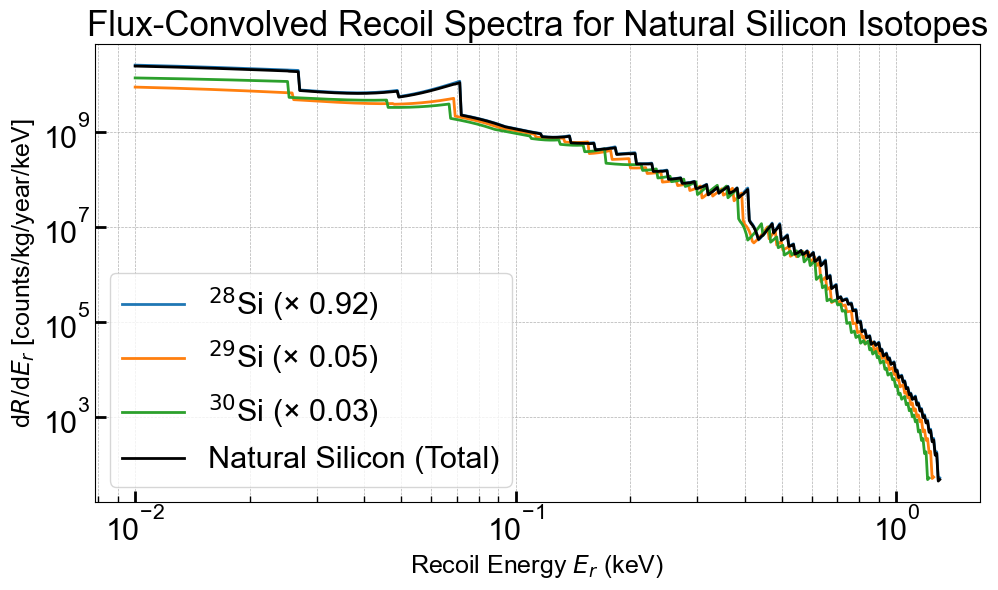

&nbsp;

&nbsp;



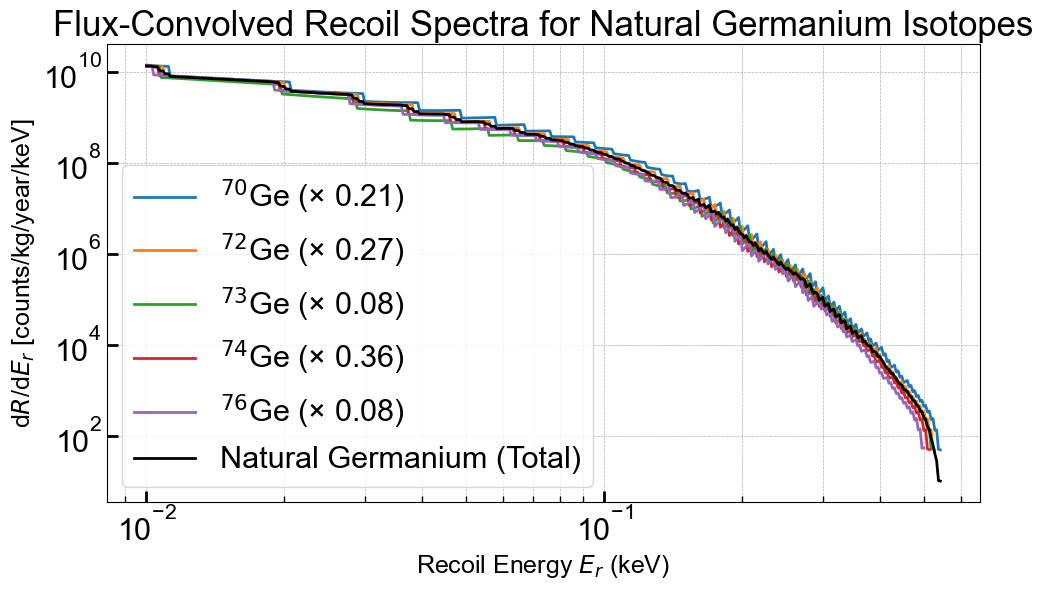


Comparing ^28Si to Natural Si at selected recoil energies (keV):
  E_r = 0.050 keV:  ^28Si = 5.651e+09,  Natural Si = 5.493e+09,  Diff = 1.58e+08 (2.88%)
  E_r = 0.100 keV:  ^28Si = 1.154e+09,  Natural Si = 1.142e+09,  Diff = 1.23e+07 (1.08%)
  E_r = 0.499 keV:  ^28Si = 5.256e+06,  Natural Si = 5.202e+06,  Diff = 5.38e+04 (1.03%)
  E_r = 0.995 keV:  ^28Si = 9.327e+03,  Natural Si = 9.123e+03,  Diff = 2.04e+02 (2.24%)
  E_r = 9.977 keV:  ^28Si = 0.000e+00,  Natural Si = 0.000e+00,  Diff = 0.00e+00 (nan%)


In [5]:
# Plot DRU spectra for each Silicon isotope with fixes for log-scale visualization

plt.figure(figsize=(10, 6))

for A, dru_vec in dru_dists_kg_yr.items():
    # Replace zero values with NaN to avoid log(0) errors in log-scale plots
    safe = np.where(dru_vec == 0, np.nan, dru_vec)
    abundance = si_isotopes[(14, A)]["abundance"]
    plt.plot(erange, safe, label=f"$^{{{A}}}$Si (× {abundance:.2f})")

# Plot combined natural silicon total
safe_total = np.where(combined_spectrum == 0, np.nan, combined_spectrum)
plt.plot(erange, safe_total, label="Natural Silicon (Total)", color="black", linewidth=2)



# Log-log scaling for better visibility
plt.xscale("log")
plt.yscale("log")

# Labels and styling
plt.xlabel("Recoil Energy $E_r$ (keV)", fontsize=18)
plt.ylabel(r'd$R$/d$E_r$ [counts/kg/year/keV]', fontsize=18)
plt.title("Flux-Convolved Recoil Spectra for Natural Silicon Isotopes", fontsize=25)
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


# Spacer
from IPython.display import display, Markdown
display(Markdown("&nbsp;\n\n&nbsp;\n\n"))  # Adds vertical space


# Plot DRU spectra for each Germanium isotope
plt.figure(figsize=(10, 6))

for A, dru_vec in dru_dists_kg_yr_ge.items():
    # Replace zero values with NaN to avoid log(0) errors in log-scale plots
    safe = np.where(dru_vec == 0, np.nan, dru_vec)
    abundance = ge_isotopes[(32, A)]["abundance"]
    plt.plot(erange, safe, label=f"$^{{{A}}}$Ge (× {abundance:.2f})")

# Plot combined natural germanium total
safe_total_ge = np.where(combined_spectrum_ge == 0, np.nan, combined_spectrum_ge)
plt.plot(erange, safe_total_ge, label="Natural Germanium (Total)", color="black", linewidth=2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Recoil Energy $E_r$ (keV)", fontsize=18)
plt.ylabel(r'd$R$/d$E_r$ [counts/kg/year/keV]', fontsize=18)
plt.title("Flux-Convolved Recoil Spectra for Natural Germanium Isotopes", fontsize=25)
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

# Compare ^28Si to Natural Silicon spectrum at a few recoil energies
target_A = 28
dru_28Si = dru_dists_kg_yr[target_A]           # ^28Si spectrum
dru_nat_Si = combined_spectrum                 # Natural Si spectrum
energies_to_check = [0.05, 0.1, 0.5, 1.0, 10.0]  # keV

print(f"\nComparing ^28Si to Natural Si at selected recoil energies (keV):")
for E in energies_to_check:
    idx = np.argmin(np.abs(erange - E))  # find closest index in erange
    val_28Si = dru_28Si[idx]
    val_nat  = dru_nat_Si[idx]
    diff     = val_28Si - val_nat
    rel_diff = 100 * diff / val_nat if val_nat > 0 else float('nan')
    print(f"  E_r = {erange[idx]:.3f} keV:  ^28Si = {val_28Si:.3e},  Natural Si = {val_nat:.3e},  Diff = {diff:.2e} ({rel_diff:.2f}%)")


## Plot Features and Interpretation

We visualize the flux-convolved recoil spectra with the following features:

- X-axis: Recoil energy $E_r$ in keV — the amount of energy transferred to the nucleus by the incoming neutron.
- Y-axis (log scale): Differential recoil rate in [counts / kg / year / keV] — the expected frequency of recoils depositing energy $E_r$.
- Logarithmic scaling is used on both axes to display the full dynamic range of recoil events, which span several orders of magnitude in both energy and event rate.
- Grid and legend: Enhance clarity, label isotope contributions, and distinguish total (natural) spectra.

The two figures show results for:

- Natural Silicon: Includes $^{28}$Si, $^{29}$Si, and $^{30}$Si, weighted by their natural abundances.
- Natural Germanium: Includes $^{70}$Ge, $^{72}$Ge, $^{73}$Ge, $^{74}$Ge, and $^{76}$Ge, also weighted by natural abundances.

These plots represent realistic recoil energy spectra for silicon- and germanium-based detectors, fully accounting for:

- The incoming neutron energy distribution (from SNOLAB flux),
- The differential cross sections of each isotope,
- And the natural abundance weighting to form the full elemental spectrum.

Key features observed in both spectra:

- High event rates at low recoil energies: Most neutrons do not impart large energy per collision; low-energy recoils are more probable.
- Steep decline with increasing $E_r$: The rate of recoils drops rapidly due to both kinematic constraints and fewer high-energy neutrons in the flux.
- Element-specific differences:
    - Silicon shows sharper structure in its spectrum, partly due to more pronounced features in the elastic scattering cross sections.
    - Germanium exhibits a smoother overall decline, but subtle variations across isotopes may arise from nuclear structure effects.

These spectra are critical for predicting detector response, understanding background rates, and designing rare-event search experiments such as dark matter or neutrino detectors.